In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import scanpy as sc
import muon as mu
import anndata
import mudata
import pandas as pd

In [3]:
adata = sc.read("data/human_pancreas_norm_complexBatch.h5ad")
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'

In [4]:
adata_scvi = sc.read("reports/scvi_pancreas.h5ad")
adata_scvi

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'scVI'
    layers: 'counts'

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)

## Unintegrated

In [6]:
sc.tl.pca(adata)

In [7]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [8]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


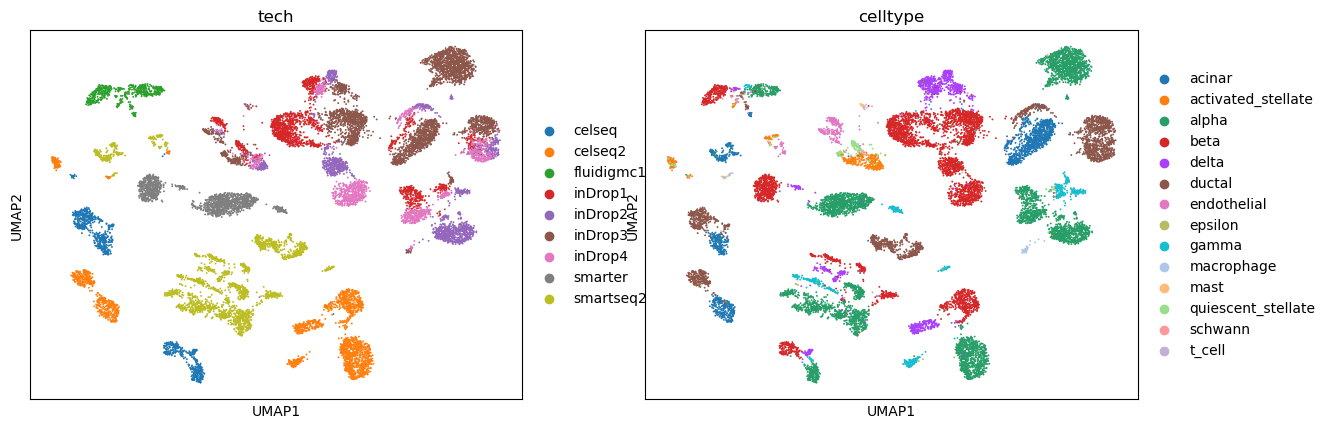

In [9]:
sc.pl.umap(adata, color=["tech", "celltype"])

## VAE

In [10]:
from src.types import TrainParams
from src.vae.model import VAE
from src.model import ModelParams

model_params = ModelParams(beta=0.01, n_layers=2, z_dim=100, n_hidden=300, use_cuda=True)
torch.set_num_threads(16)

model = VAE(adata, model_params)
train_params = TrainParams(train_size=0.8, n_epochs=100, learning_rate=1e-4, batch_size=128, params_file="benchmark_human_pancreas_metrics")

In [11]:
model_dict = torch.load('mvae_params/pancreas_unnorm_20230407-183954.pt', map_location='cuda')
model.load_state_dict(model_dict)

<All keys matched successfully>

In [13]:
from src.vae.train import to_latent
emb = to_latent(model, adata, ["tech"], train_params)
adata.obsm["X_vae"] = np.vstack([x.numpy() for x in emb])

100%|██████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 25.83it/s]


## VAE MNN only

In [14]:
model = VAE(adata, model_params)
model_dict = torch.load('mvae_params/pancreas_512_20230408-210818.pt', map_location='cuda')
model.load_state_dict(model_dict)

<All keys matched successfully>

In [16]:
emb = to_latent(model, adata, ["tech"], train_params)
adata.obsm["X_vae_mnn"] = np.vstack([x.numpy() for x in emb])

100%|██████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 29.21it/s]


/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


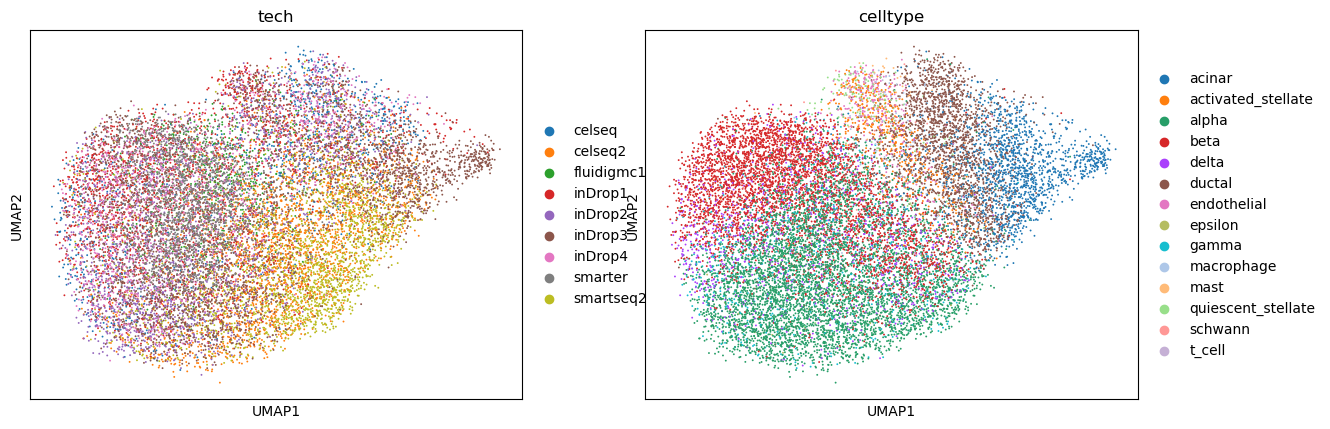

In [18]:
sc.pp.neighbors(adata, use_rep="X_vae_mnn", n_neighbors=30)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["tech", "celltype"],
)

## Harmony

In [19]:
import scanpy.external as sce
sce.pp.harmony_integrate(adata, 'tech')

2023-04-15 21:40:24,221 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/threadpoolctl.py:762: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
2023-04-15 21:40:27,581 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-04-15 21:40:27,624 - harmonypy - INFO - Iteration 1 of 10
2023-04-15 21:40:30,156 - harmonypy - INFO - Iteration 2 of 10
2023-04-15 21:40:32,665 - harmonypy - INFO - Iteration 3 of 10
2023-04-15 21:40:35,194 - harmonypy - INFO - Iteration 4 of 1

/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


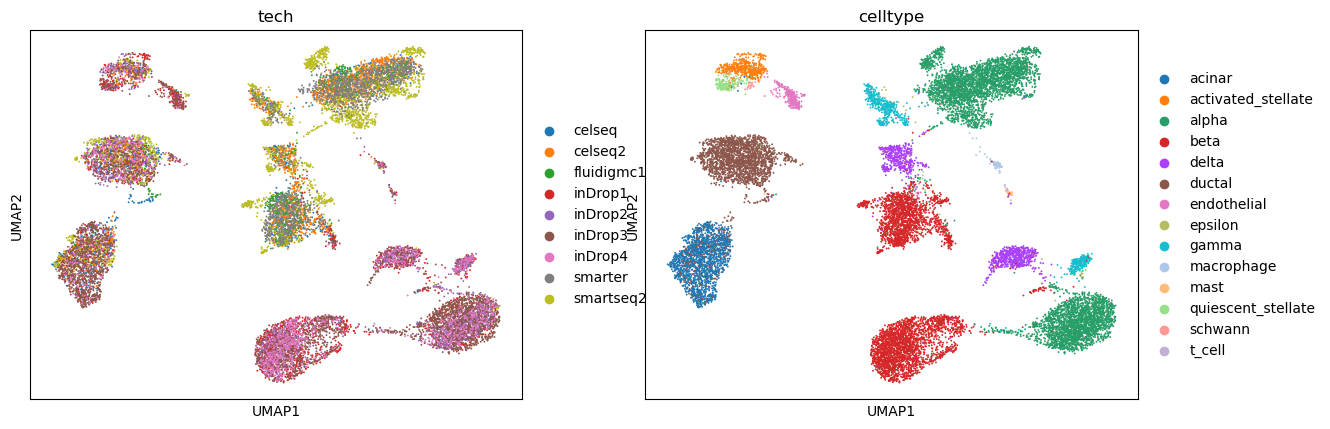

In [24]:
sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=30)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=["tech", "celltype"],
)

In [25]:
adata.obsm["scVI"] = adata_scvi.obsm["scVI"]

In [26]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["Unintegrated", "X_vae", "X_vae_mnn", "X_pca_harmony", "scVI"],
    n_jobs=12,
)
bm.benchmark()

Metrics:   0%|                                     | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]WARNING:jax._src.lib.xla_bridge:No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)

Metrics:  60%|██████████████████            | 6/10 [00:30<00:15,  3.84s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  80%|████████████████████████      | 8/10 [00:39<00:11,  5.69s/it, Batch correction: pcr_comparison]/media/gambino/students_workdir/anna/miniconda3/envs/ak/lib/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(

Metrics:   0%|                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                             
Metrics:  60%|██████████████████            | 6/10 [00:43<00:18,  4.60s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:   0%|                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                             
Metrics:  60%|██████████████████            | 6/10 [00:42<00:17,  4.41s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:   0%|                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                             
Metrics:  60%|██████████████████            | 6/10 [00:23<00:09,  2.42s/it, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:   0%|                                                                        | 0/10 [00:00<?, ?it/s]
                                                                                                             
Metrics:  60%|██████████████████            | 6/10 [00:04<00:02,  1.82it/s, Batch correction: kbet_per_label]

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Embeddings: 100%|██████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.57s/it]

                                                                                                             

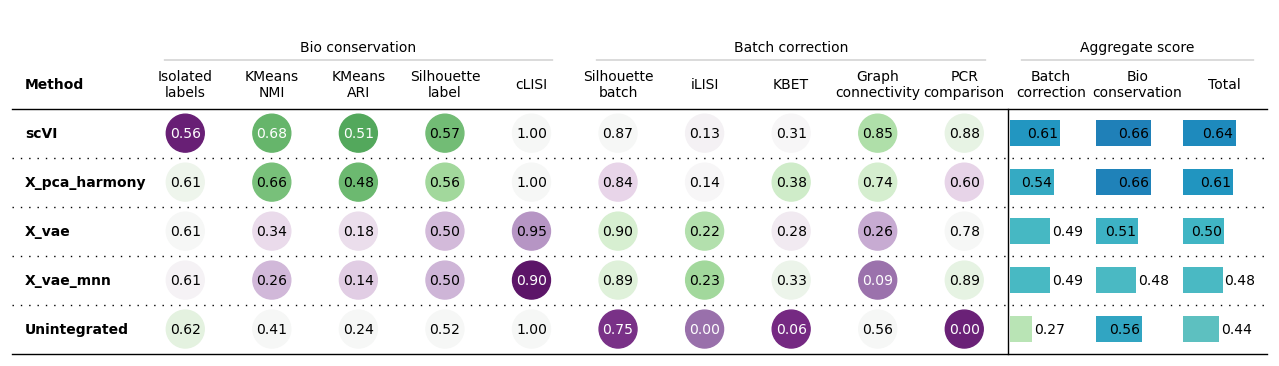

In [27]:
bm.plot_results_table(min_max_scale=False)